# This notebook is for the Fair-Shapely experiment

In [1]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [3]:
from src.data.unified_dataloader import load_dataset

a, processed_compas = load_dataset('compas')

In [4]:
processed_compas.head(3)

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,2.875313,-0.141855,-0.187414,-0.218065,-0.711240,0,0,0,0,0,1,1,0,1,0,1,0,0
1,1,-0.068808,-0.141855,-0.187414,-0.218065,-0.711240,1,0,0,0,0,0,1,0,1,0,1,0,1
2,1,-0.909985,-0.141855,-0.187414,1.775750,0.108063,1,0,0,0,0,0,1,0,1,0,1,0,1


### 3. Split label/unlabel data, split train/test data.

In [5]:
'''COMPAS'''
df = processed_compas.copy()
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

In [6]:
from src.evaluation.five_fold_cross_validation import evaluate_model
model = XGBClassifier()
evaluate_model(model=model, X_train=X, y_train=y, num_folds=5, dataset_name='compas')

c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-------------------------------------
-------------1th fold----------------
-------------------------------------
1. Split the compas dataset into majority group and minority group (label 0 and label 1)
2. 初始化FairnessExplainer
--------接下来先对minority group进行修改--------
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用FairSHAP, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用FairSHAP, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
在X_train_minority中shapely value中大于0.1的值的个数有: 53
--------接下来对majority group进行修改--------
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
在X_train_majority中shapely value中大于0.1的值的个数有: 496
6. 计算origin

### 4. read saved_csv file and make plots

In [11]:
def extract_original_values(fold):
    original_DR = fold.loc[0,'new_DR']
    original_DP = fold.loc[0,'new_DP']
    original_EO = fold.loc[0,'new_EO']
    original_PQP = fold.loc[0,'new_PQP']
    return original_DR, original_DP, original_EO, original_PQP

In [12]:
''' german credit dataset '''

fold1 = pd.read_csv('saved_results/compas/1-fold_results.csv')
fold2 = pd.read_csv('saved_results/compas/2-fold_results.csv')
fold3 = pd.read_csv('saved_results/compas/3-fold_results.csv')
fold4 = pd.read_csv('saved_results/compas/4-fold_results.csv')
fold5 = pd.read_csv('saved_results/compas/5-fold_results.csv')

fold1_original_DR, fold1_original_DP, fold1_original_EO, fold1_original_PQP = extract_original_values(fold1)
fold2_original_DR, fold2_original_DP, fold2_original_EO, fold2_original_PQP = extract_original_values(fold2)
fold3_original_DR, fold3_original_DP, fold3_original_EO, fold3_original_PQP = extract_original_values(fold3)
fold4_original_DR, fold4_original_DP, fold4_original_EO, fold4_original_PQP = extract_original_values(fold4)
fold5_original_DR, fold5_original_DP, fold5_original_EO, fold5_original_PQP = extract_original_values(fold5)

fold1.drop(fold1.index[0], inplace=True)
fold2.drop(fold2.index[0], inplace=True)
fold3.drop(fold3.index[0], inplace=True)
fold4.drop(fold4.index[0], inplace=True)
fold5.drop(fold5.index[0], inplace=True)

fold1.head(3)

,action_number,new_DR,new_DP,new_EO,new_PQP
1,1,0.088519,0.159567,0.151072,0.048557
2,2,0.086789,0.172979,0.169764,0.047713
3,3,0.082280,0.149626,0.097856,0.009794


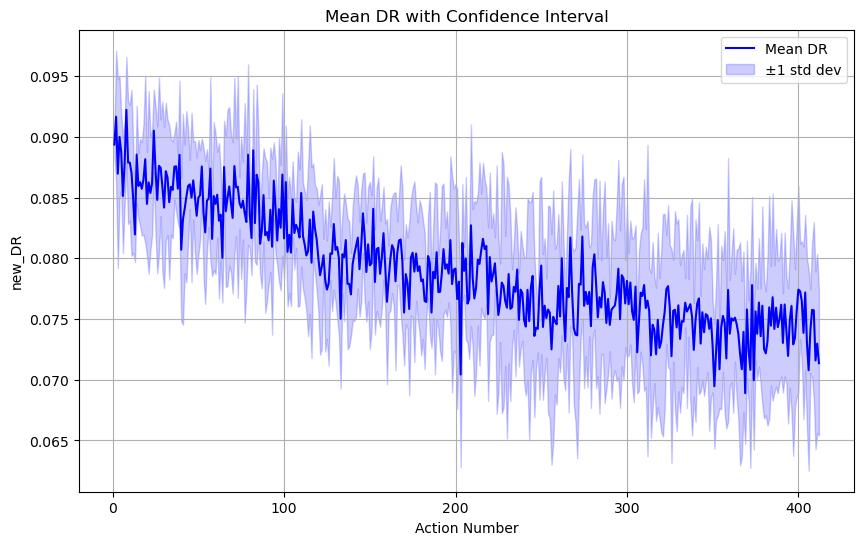

In [13]:
import matplotlib.pyplot as plt

for fold in [fold1, fold2, fold3, fold4, fold5]:
    fold['action_number'] = pd.to_numeric(fold['action_number'])

min_action = 1
max_action = min([
    len(fold1['action_number']),
    len(fold2['action_number']),
    len(fold3['action_number']),
    len(fold4['action_number']),
    len(fold5['action_number'])
])

# 创建一个包含所有可能action_number的列表
action_range = np.arange(min_action, max_action + 1)

# 创建一个字典来存储每个action_number对应的new_DR值
dr_values = {action: [] for action in action_range}

# 收集每个action_number对应的所有new_DR值
for fold in [fold1, fold2, fold3, fold4, fold5]:
    mask = (fold['action_number'] >= min_action) & (fold['action_number'] <= max_action)
    for action, dr in zip(fold.loc[mask, 'action_number'], fold.loc[mask, 'new_DR']):
        dr_values[action].append(dr)

# 计算每个action_number的均值和标准差
means = []
stds = []
for action in action_range:
    values = dr_values[action]
    means.append(np.mean(values))
    stds.append(np.std(values))

# 转换为numpy数组以便于计算
means = np.array(means)
stds = np.array(stds)

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制均值线
plt.plot(action_range, means, 'b-', label='Mean DR')

# 绘制填充区域（均值±标准差）
plt.fill_between(action_range, 
                 means - stds,
                 means + stds,
                 alpha=0.2,
                 color='b',
                 label='±1 std dev')

plt.xlabel('Action Number')
plt.ylabel('new_DR')
plt.title('Mean DR with Confidence Interval')
plt.legend()
plt.grid(True)

# 显示图形
plt.show()

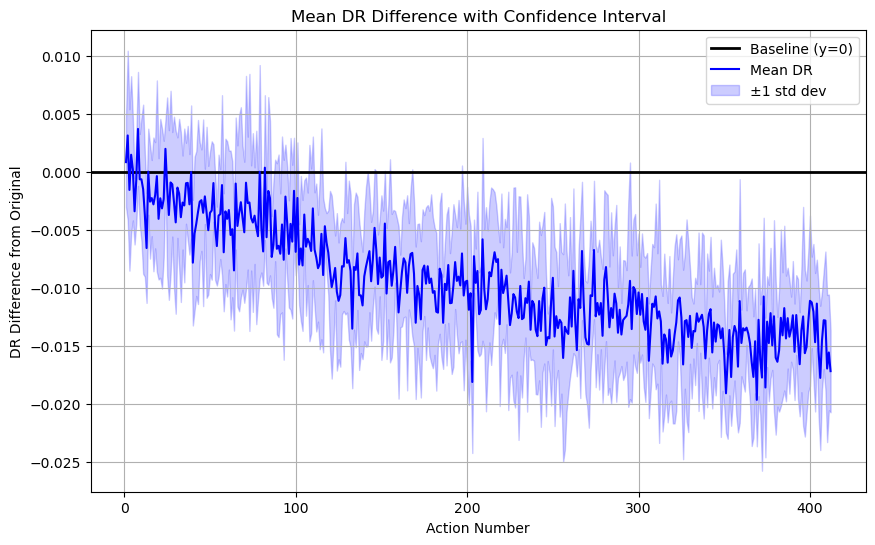

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 首先确保所有DataFrame中的action_number列都是数值类型
for fold in [fold1, fold2, fold3, fold4, fold5]:
    fold['action_number'] = pd.to_numeric(fold['action_number'])

# 减去各自的original_DR
fold1['new_DR'] = fold1['new_DR'] - fold1_original_DR
fold2['new_DR'] = fold2['new_DR'] - fold2_original_DR
fold3['new_DR'] = fold3['new_DR'] - fold3_original_DR
fold4['new_DR'] = fold4['new_DR'] - fold4_original_DR
fold5['new_DR'] = fold5['new_DR'] - fold5_original_DR

# 找到最小的action_number范围
min_action = max([
    fold1['action_number'].min(),
    fold2['action_number'].min(),
    fold3['action_number'].min(),
    fold4['action_number'].min(),
    fold5['action_number'].min()
])

max_action = min([
    fold1['action_number'].max(),
    fold2['action_number'].max(),
    fold3['action_number'].max(),
    fold4['action_number'].max(),
    fold5['action_number'].max()
])

# 创建一个包含所有可能action_number的列表
action_range = np.arange(min_action, max_action + 1)

# 创建一个字典来存储每个action_number对应的new_DR值
dr_values = {action: [] for action in action_range}

# 收集每个action_number对应的所有new_DR值
for fold in [fold1, fold2, fold3, fold4, fold5]:
    mask = (fold['action_number'] >= min_action) & (fold['action_number'] <= max_action)
    for action, dr in zip(fold.loc[mask, 'action_number'], fold.loc[mask, 'new_DR']):
        dr_values[action].append(dr)

# 计算每个action_number的均值和标准差
means = []
stds = []
for action in action_range:
    values = dr_values[action]
    means.append(np.mean(values))
    stds.append(np.std(values))

# 转换为numpy数组以便于计算
means = np.array(means)
stds = np.array(stds)

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制加粗的y=0基准线
plt.axhline(y=0, color='black', linewidth=2, linestyle='-', label='Baseline (y=0)')

# 绘制均值线
plt.plot(action_range, means, 'b-', label='Mean DR')

# 绘制填充区域（均值±标准差）
plt.fill_between(action_range, 
                 means - stds,
                 means + stds,
                 alpha=0.2,
                 color='b',
                 label='±1 std dev')

plt.xlabel('Action Number')
plt.ylabel('DR Difference from Original')
plt.title('Mean DR Difference with Confidence Interval')
plt.legend()
plt.grid(True)

# 显示图形
plt.show()